## Time series Analysis

In [416]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [417]:
data = pd.read_csv(r'c:\Users\massimiliano.canosi\OneDrive - Adecco\Progetti Massi\Kaggle - Injury Prediction\AirPassengers.csv')
data.rename(columns={'Month': 'Date', '#Passengers': 'Number of Passengers'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

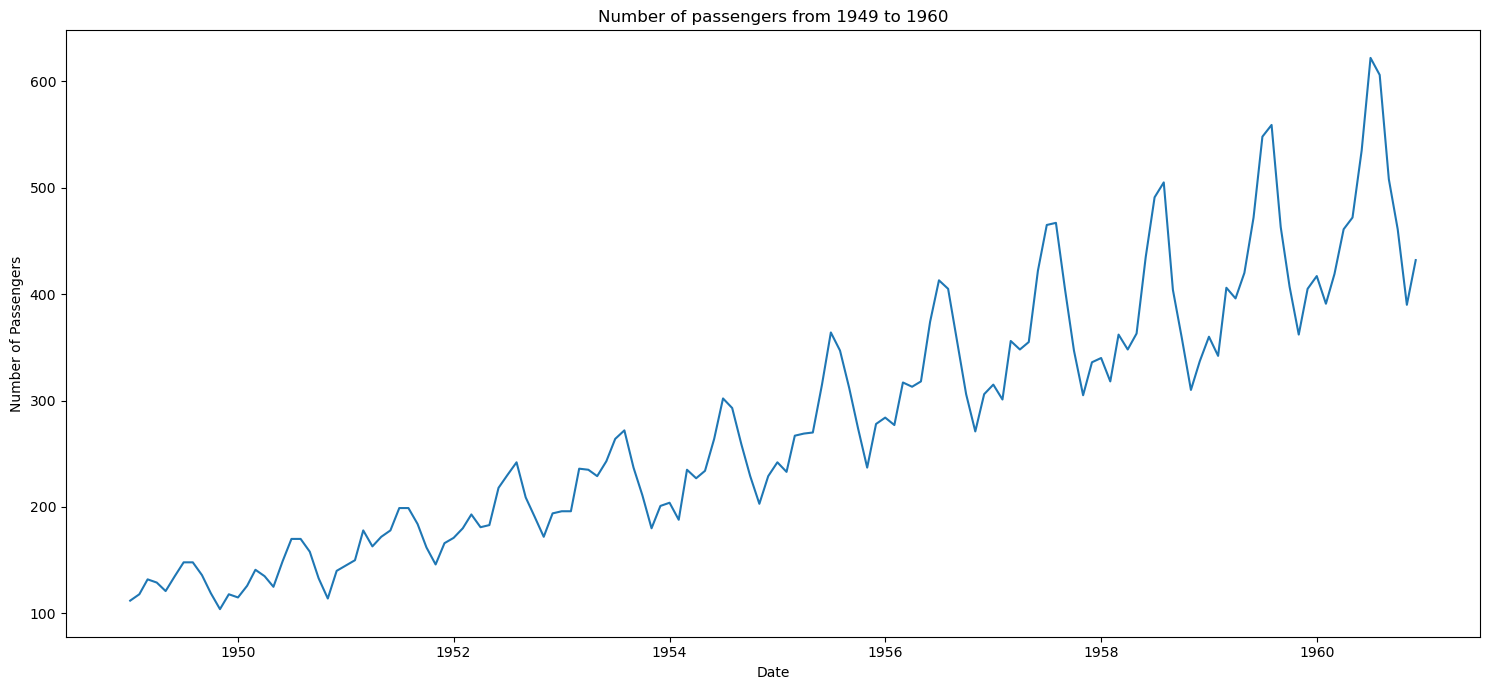

In [418]:
fig = plt.figure(figsize=(15,7))
sns.lineplot(data=data, x='Date', y='Number of Passengers')

plt.title("Number of passengers from 1949 to 1960")
plt.tight_layout()
plt.show()

#### <span style='color: yellow'> This plot has a non-costant mean and variance, and a seasonal component </span>
#### Let's decompose the series and then apply the stationarity tests (from here we can already see that the Series is non-stationary)

In [419]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

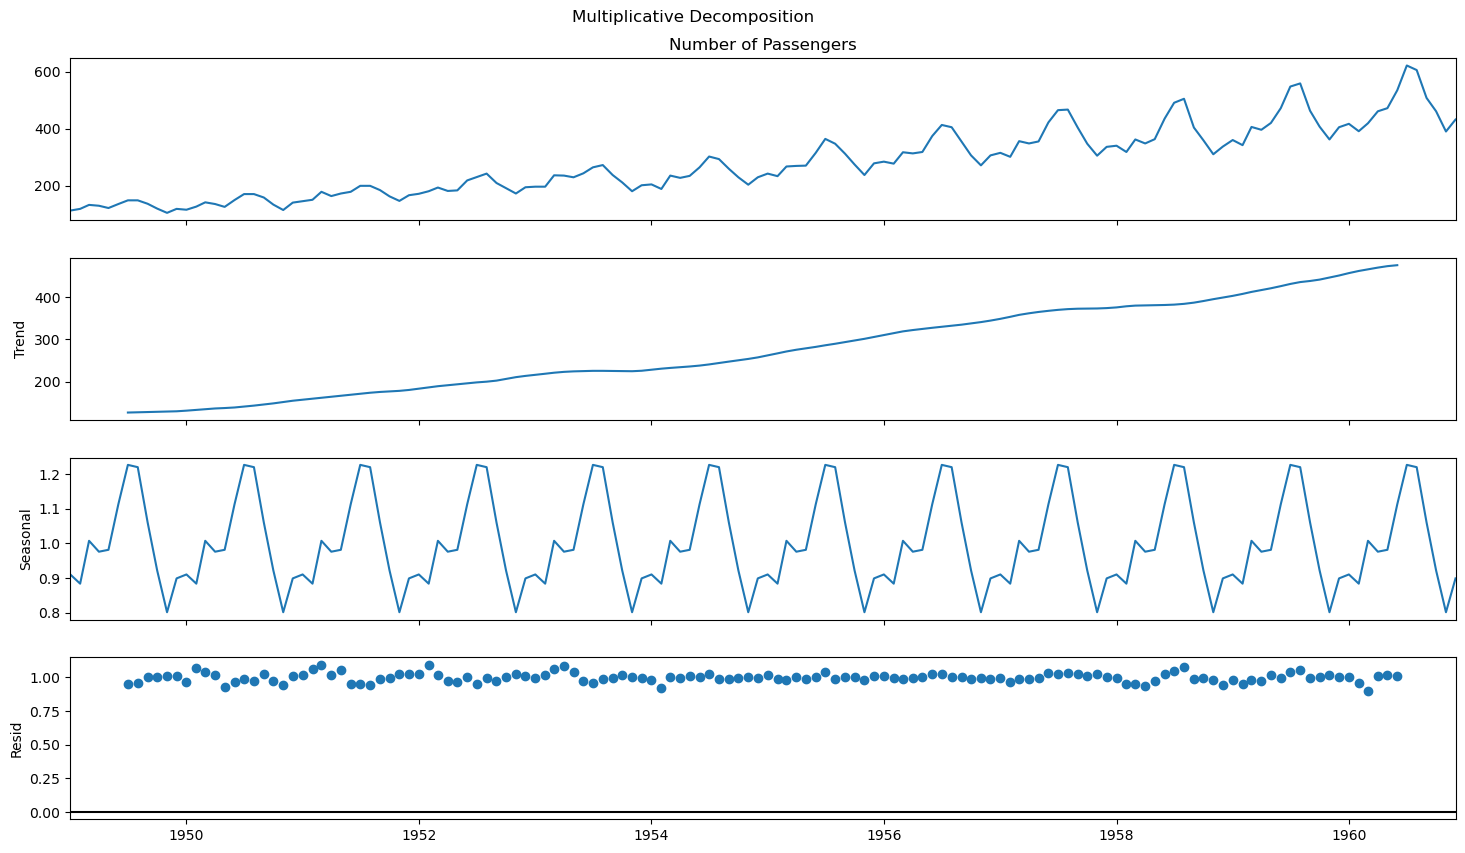

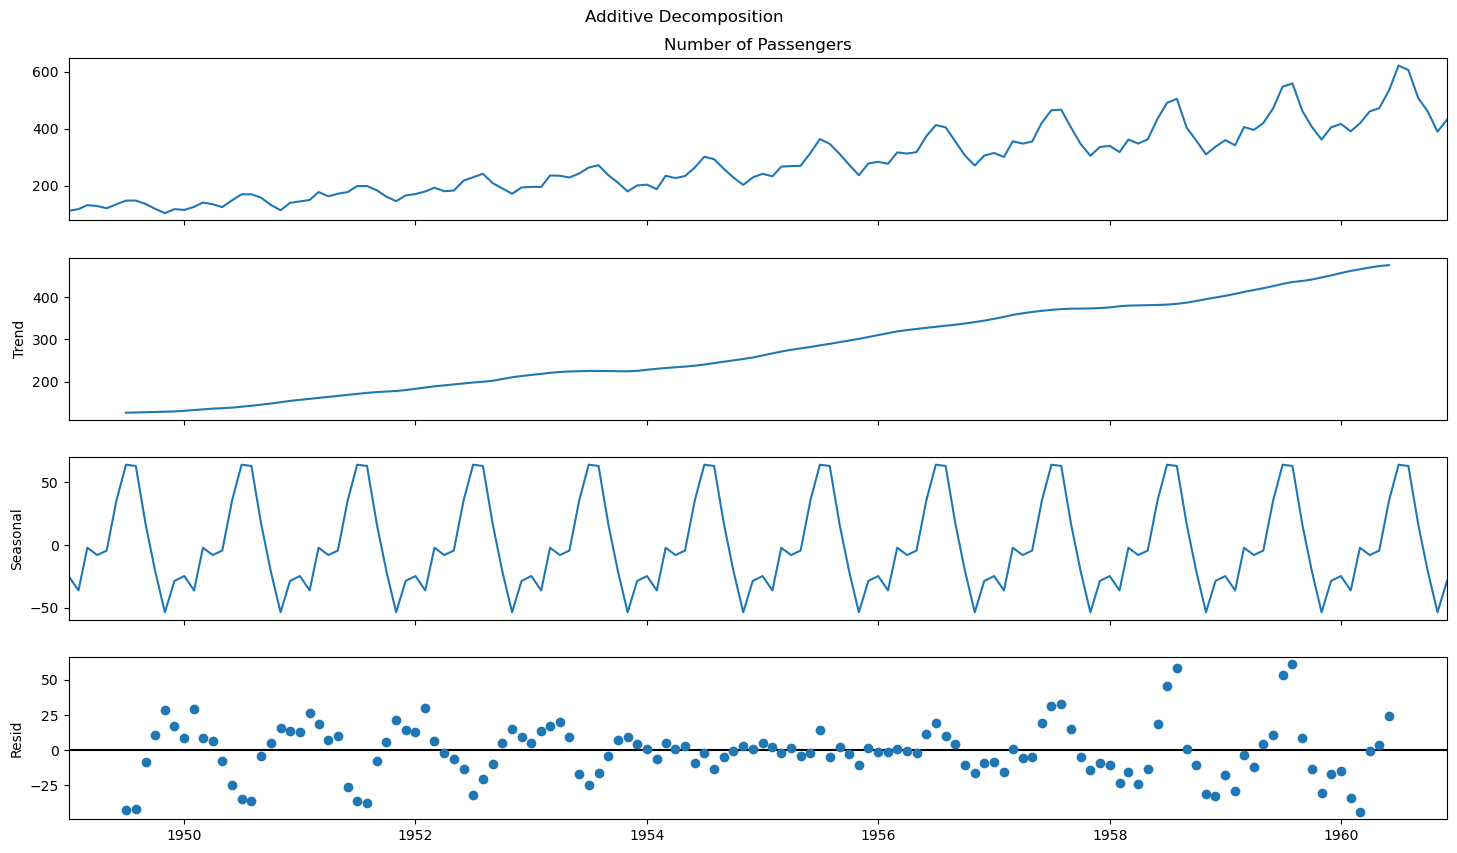

In [420]:
period = 12

multiplicative_decomposition = seasonal_decompose(data['Number of Passengers'], model='multiplicative', period=period)
additive_decomposition = seasonal_decompose(data['Number of Passengers'], model='additive', period=period)

fig1 = multiplicative_decomposition.plot()
fig1.suptitle("Multiplicative Decomposition")
fig1.set_size_inches((16, 9))

fig2 = additive_decomposition.plot()
fig2.suptitle("Additive Decomposition")
fig2.set_size_inches((16, 9))

plt.show()

### Stationarity

####  <span style='color: yellow'> We have already seen from the graph that the series is NOT stationary, but we will do some tests just as a demonstration </span>

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity

#### Null Hyp (h0) - Series is stationary
#### Alternate Hyp (h1) - Series is not stationary

In [421]:
from statsmodels.tsa.stattools import kpss, adfuller

kpss_stat, p_value, lags, crit = kpss(data['Number of Passengers'])

print("*" * 40, "Test", "*" * 40, "\n")

print(f" KPSS: {kpss_stat},\n p_value: {p_value},\n lags: {lags},\n crit: {crit}")

print("\n", "*" * 90, "\n")

if p_value < 0.05:
    print('The Series is NOT stationary')
else:
    print('The Series is Stationary')

**************************************** Test **************************************** 

 KPSS: 1.6513122354165206,
 p_value: 0.01,
 lags: 8,
 crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 ****************************************************************************************** 

The Series is NOT stationary


### Adfuller Test

#### Null Hyp (h0) - Series posesses a unit root (random walk) and hence is not stationary
#### Alternate Hyp (h1) - Series is stationary

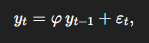

In [422]:
adff_stat, adff_pvalue, adff_lags, nobs, adff_crit, icbest = adfuller(data['Number of Passengers'])

print("*" * 40, "Test", "*" * 40, "\n")

print(f" ADFF: {adff_stat},\n p_value: {adff_pvalue},\n lags: {adff_lags},\n nobs: {nobs},\n critical values: {adff_crit},\n icbest: {icbest}")

print("\n", "*" * 90, "\n")

if adff_pvalue > 0.05:
    print('The Series is NOT stationary')
else:
    print('The Series is Stationary')

## !!! ...AND ADFF (test statistic) > critical values at each threshold !!!

**************************************** Test **************************************** 

 ADFF: 0.8153688792060482,
 p_value: 0.991880243437641,
 lags: 13,
 nobs: 130,
 critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598},
 icbest: 996.692930839019

 ****************************************************************************************** 

The Series is NOT stationary


### Stationarity transformation

In [423]:
log_ts = np.log(data)
differentiated_series = log_ts.diff().dropna()
differentiated_series

,Number of Passengers
Date,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


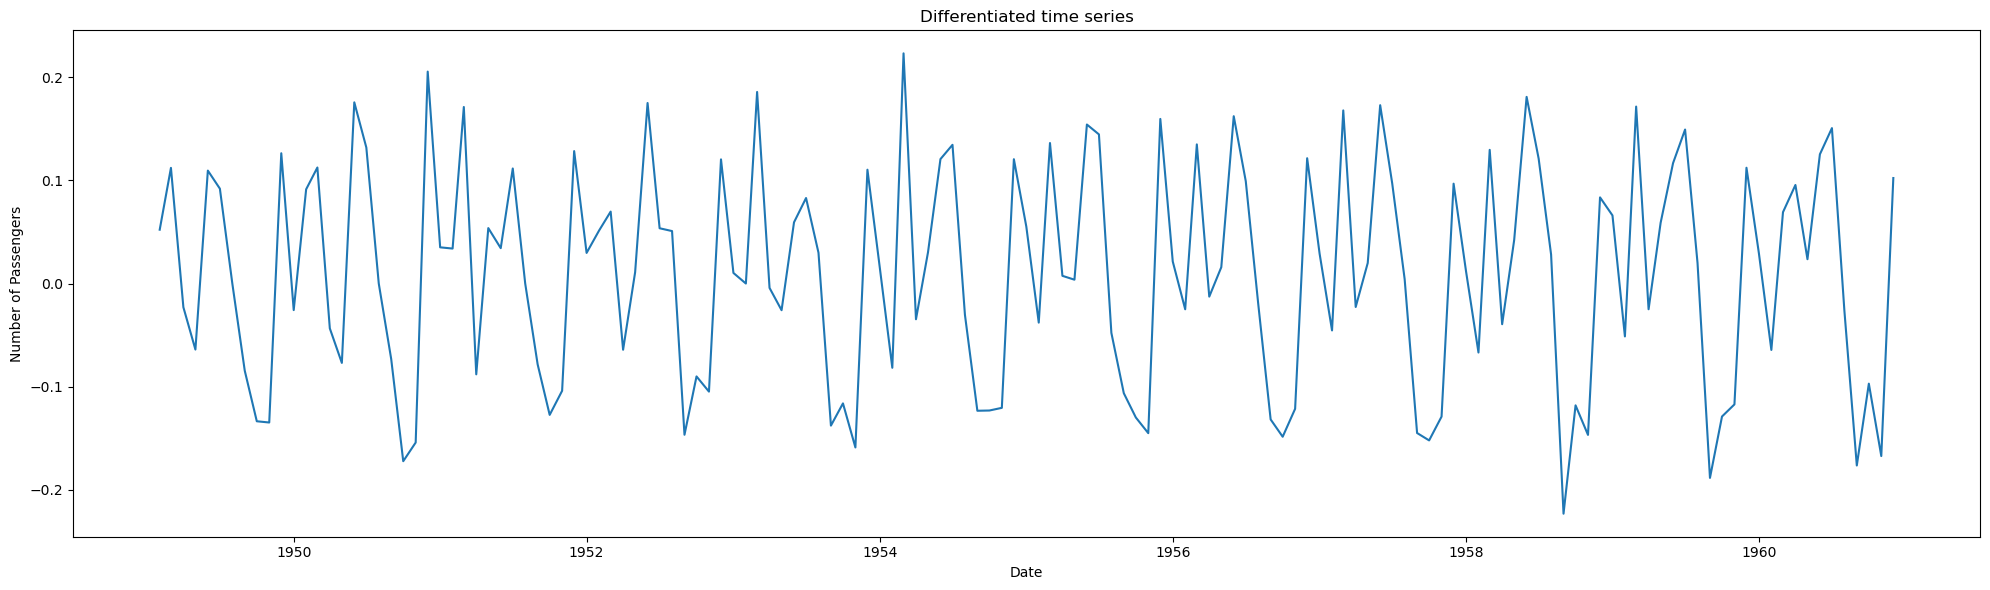

In [424]:
fig = plt.figure(figsize=(20,6))
sns.lineplot(data=differentiated_series, x='Date', y='Number of Passengers')

plt.title("Differentiated time series")
plt.tight_layout()
plt.show()

## ACF / PACF

In [425]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### before differencing

<Figure size 2000x1000 with 0 Axes>

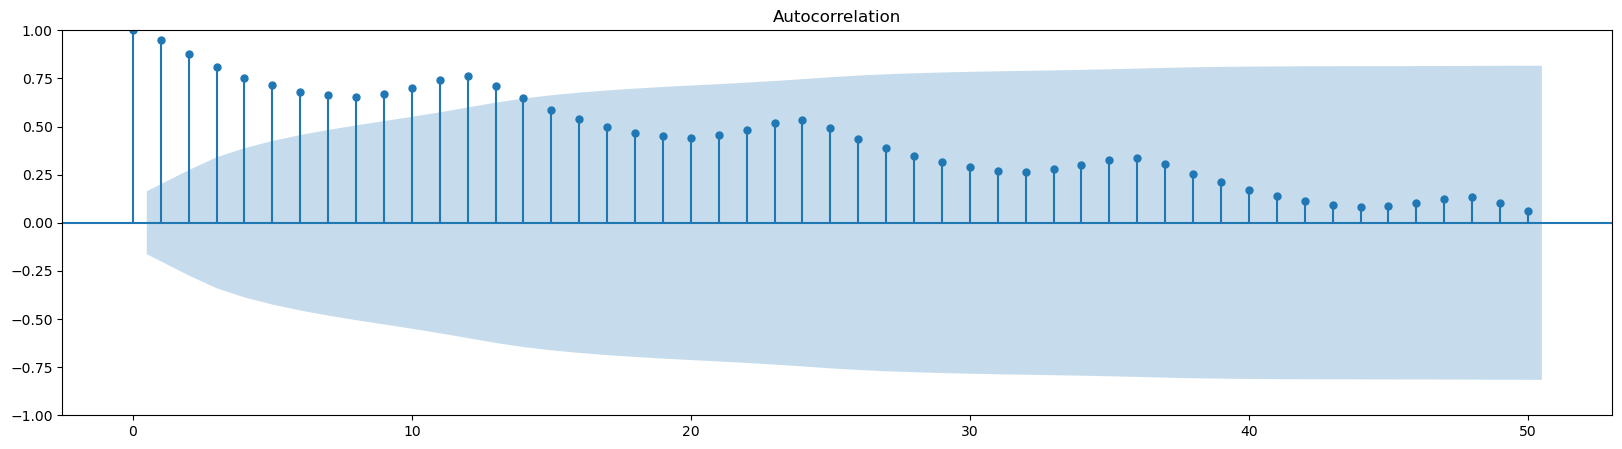

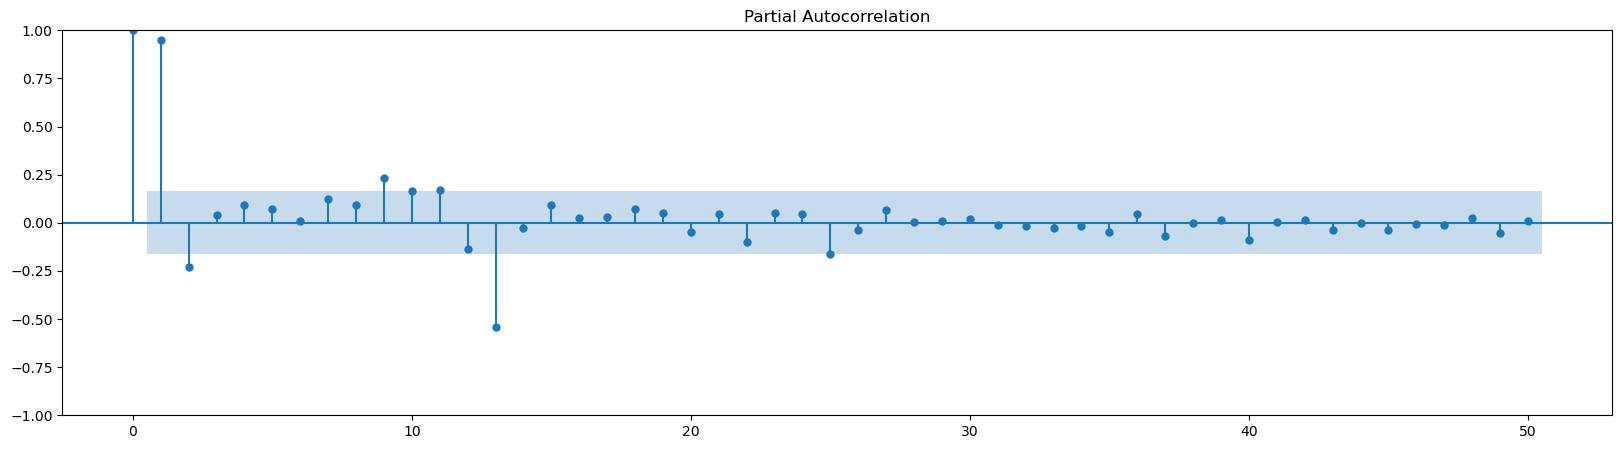

In [426]:
fig = plt.figure(figsize=(20,10))

acf = plot_acf(data['Number of Passengers'], alpha=0.05, lags=50)
acf.set_size_inches((20,5))
pacf = plot_pacf(data['Number of Passengers'], alpha=0.05, lags=50)
pacf.set_size_inches((20, 5))

plt.show()

### first differencing w/out seasonal differencing

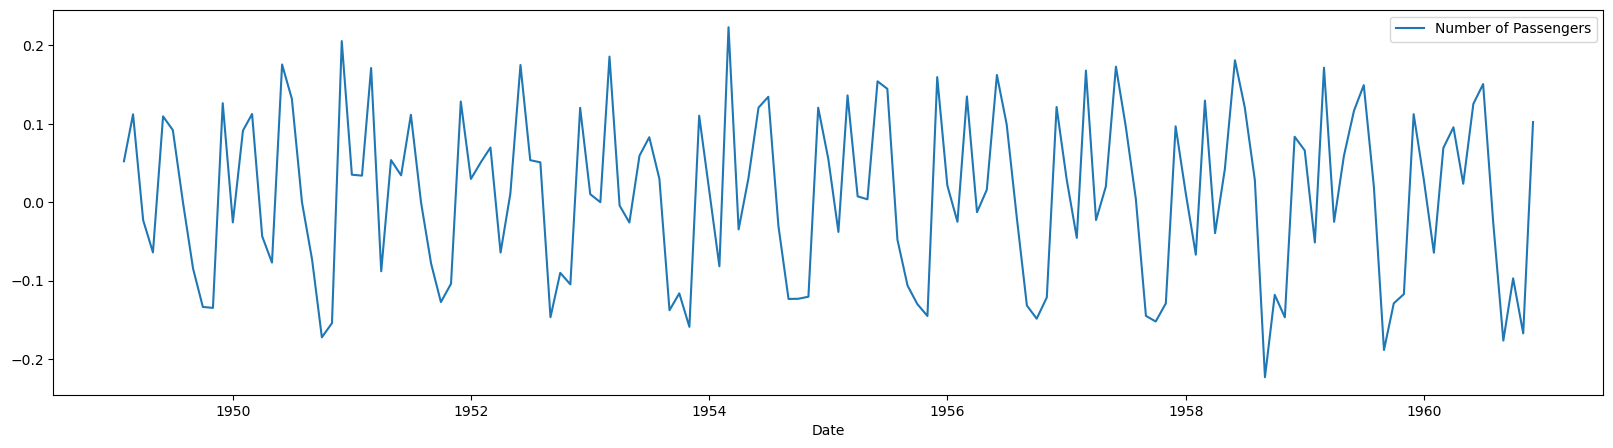

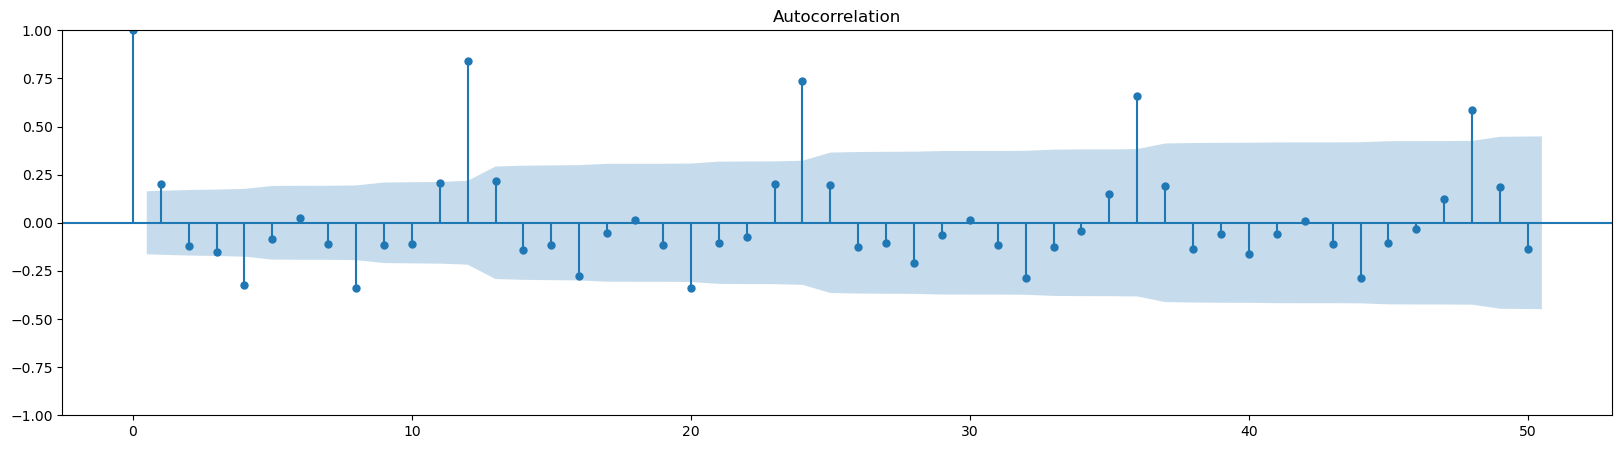

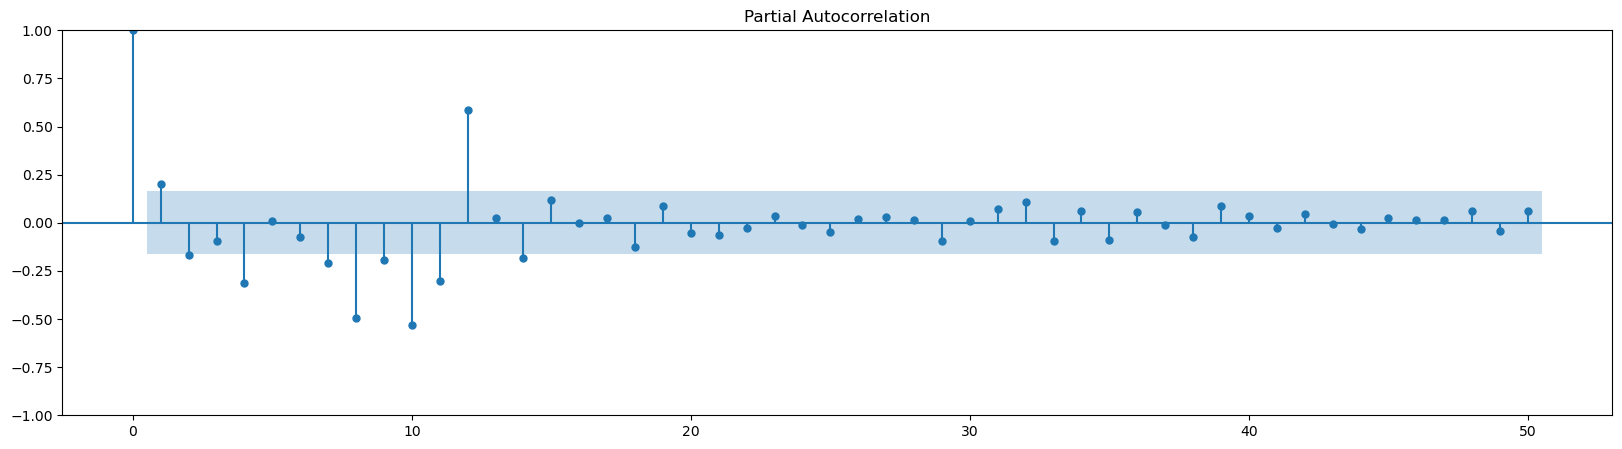

In [427]:
fig = plt.figure(figsize=(20,5))


sns.lineplot(differentiated_series)

acf = plot_acf(differentiated_series['Number of Passengers'], alpha=0.05, lags=50)
acf.set_size_inches((20,5))

pacf = plot_pacf(differentiated_series['Number of Passengers'], alpha=0.05, lags=50)
pacf.set_size_inches((20, 5))

plt.show()

In [428]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from copy import deepcopy
import numpy as np

model_df = deepcopy(data)
model_df.reset_index(inplace=True)

x = model_df['Date']
y = model_df['Number of Passengers']

train = model_df.iloc[:len(model_df)-12]['Number of Passengers']
test = model_df.iloc[len(model_df)-12:]['Number of Passengers']

model = pm.auto_arima(train, 
                    start_p = 1, 
                    start_q = 1,
                    max_p = 3, 
                    max_q = 3, 
                    m = 12,
                    start_P = 0, 
                    seasonal = True,
                    d = None, 
                    D = 1, 
                    trace = True,
                    error_action ='ignore',   
                    suppress_warnings = True,
                    stepwise = True
                ) 

print("-" * 25)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=907.364, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=1.03 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=1.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=1.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.25 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.77 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=1.41 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.84 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=1.25 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            lun, 28 apr 2025   AIC                            905.686
Time:                                    13:31:12   BIC                            919.623
Sample:                                         0   HQIC                           911.346
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Residuals auto-correlation (LB-test) --> 0.00 --> No autocorrelation (<= 0.05 then random walk, > 0.05 then white noise)

#### Jarque-Bera --> Prob(JB) = 0.24 > 0.05 --> H0 = normal dist -->  the distribution of the residuals are not deviating significatively from the normal distribution

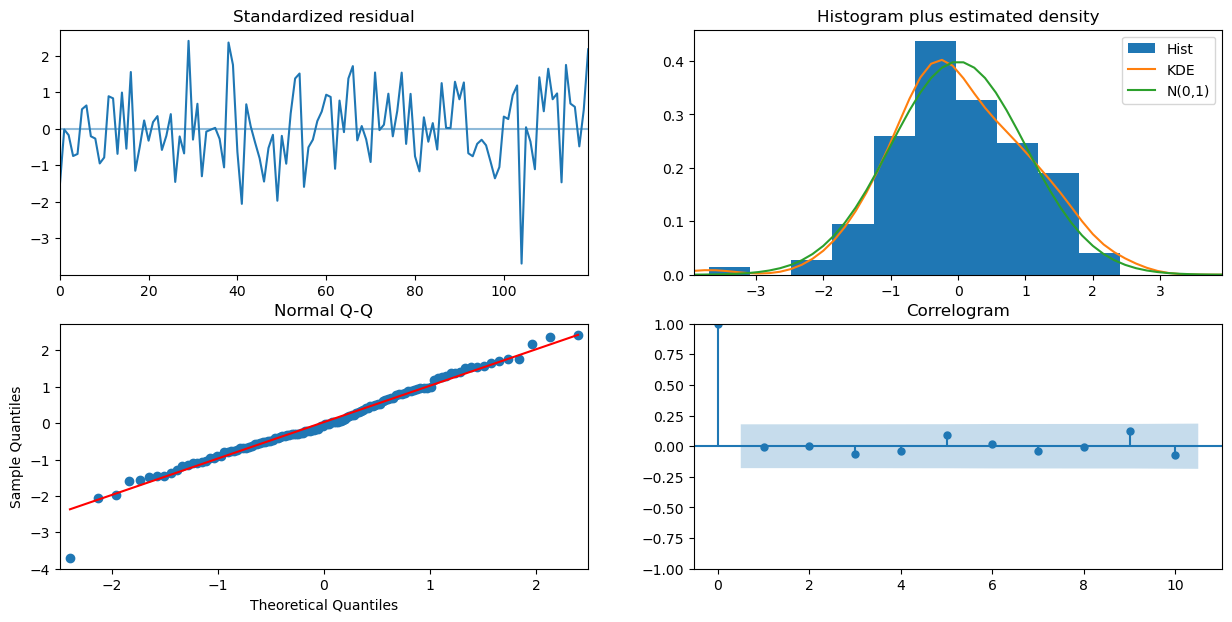

In [434]:
model.plot_diagnostics(figsize=(15,7))
plt.show()

#### The primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. In this case, our model diagnostics suggests that the model residuals are normally distributed

In [430]:
forecasts = model.predict(n_periods=test.shape[0] + 60, return_conf_int=True)

confidence_interval_arima = pd.DataFrame(forecasts[1])
forecasted = forecasts[0]
lower_confidence_interval_arima = confidence_interval_arima.loc[:, 0]
upper_confidence_interval_arima = confidence_interval_arima.loc[:, 1]

## 

test_start_index = len(train)
start_date = x.iloc[test_start_index]
n_periods = len(test) + 60
all_dates = pd.date_range(start=start_date, periods=n_periods, freq='MS')

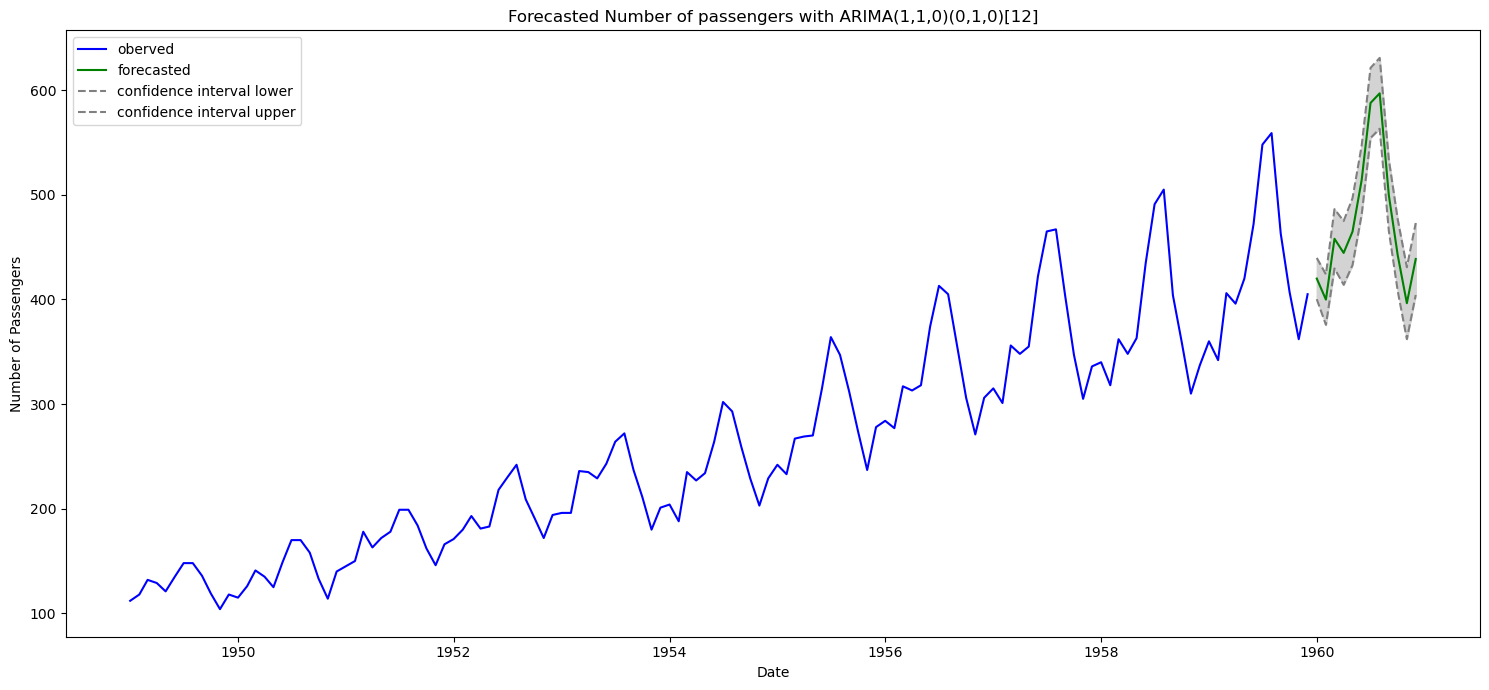

In [431]:
fig = plt.figure(figsize=(15,7))

plt.plot(x[:test_start_index], train, c='blue', label='oberved')

plt.plot(x[test_start_index:], forecasted[:len(test)], c='green', label='forecasted')
plt.plot(x[test_start_index:], lower_confidence_interval_arima[:len(test)], c='grey', label='confidence interval lower', linestyle='dashed')
plt.plot(x[test_start_index:], upper_confidence_interval_arima[:len(test)], c='grey', label='confidence interval upper', linestyle='dashed')


plt.fill_between(x[test_start_index:], lower_confidence_interval_arima[:len(test)],  upper_confidence_interval_arima[:len(test)], color='lightgrey')
plt.title("Forecasted Number of passengers with ARIMA(1,1,0)(0,1,0)[12]")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.tight_layout()
plt.show()

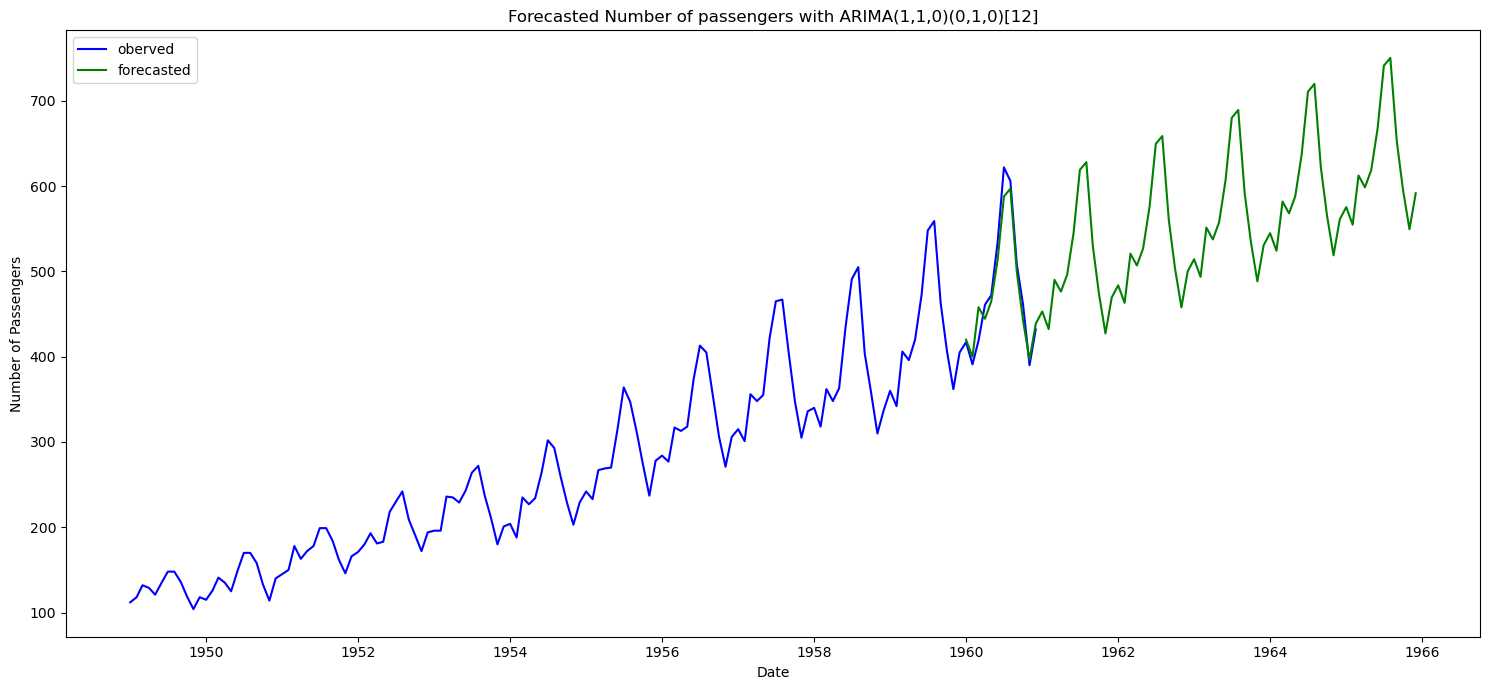

In [432]:
fig = plt.figure(figsize=(15,7))

plt.plot(x, y, c='blue', label='oberved')
plt.plot(all_dates, forecasted, c='green', label='forecasted')


plt.title("Forecasted Number of passengers with ARIMA(1,1,0)(0,1,0)[12]")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.tight_layout()
plt.show()

In [433]:
forecasted_table = pd.Series(forecasted.values, index=all_dates).reset_index()

predicted_values = forecasted_table[forecasted_table['index'] >= '1961-01-01'].reset_index(drop=True).rename(columns={0: 'Predicted Number of Passengers'})

predicted_values

,index,Predicted Number of Passengers
0,1961-01-01,453.007671
1,1961-02-01,432.400505
2,1961-03-01,490.151262
3,1961-04-01,476.315032
4,1961-05-01,496.376208
5,1961-06-01,545.508675
6,1961-07-01,619.023734
7,1961-08-01,628.098970
8,1961-09-01,530.513884
9,1961-10-01,473.257554
